# Deep Learning &mdash; Assignment 9

Assignment for week 9 of the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_November 2022_

-----

**Names:** Hauque, Federico Gabriel - Soler Sanz, Guillem

**Group:** 5

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a variational autoencoder
2. Extend the model to a conditional VAE

## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [1]:

!pip install d2l==1.0.0a1.post0
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
from d2l import torch as d2l
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.0 MB/s eta 0:00:00


## 9.1 MNIST dataset (0 points)

In this assignment we will use the MNIST digit dataset. This dataset consists of 28×28 binary images and has 60000 training examples divided over 10 classes.

**(a) Run the code below to load the MNIST dataset.**

In [2]:
opts = {'batch_size':32, 'shuffle':True}
train_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    **opts)
test_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    **opts)
num_classes = 10

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## 9.2 Variational Autoencoder (VAE) (3 points)

We will implement a Variational Autoencoder. This model consists of two networks: an encoder and a decoder.
The encoder produces a distribution in the latent space, represented as the parameters of a normal distribution. The decoder takes the latent space representation and produces an output in the data space.

**(a) Complete the implementation below.<span style="float:right"> (2 points)</span>**

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_size=2):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        self.encoder_part1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)
        
        # Components of the decoder
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_part1(x)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        eps = torch.randn_like(mean_z)
        std_z = torch.exp(0.5 * logvar_z)
        return torch.add(torch.mul(eps, std_z), mean_z)
        
        

    def decode(self, z):
        h = self.decoder_part1_z(z)
        h = torch.reshape(h, (-1,64,7,7)) # Unflatten
        return self.decoder_part2(h)

    def forward(self, x):
        mean_z, logvar_z = self.encode(x)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z), mean_z, logvar_z

In [4]:
# Here are some unit tests for the VAE
samples = VAE().sample_latent(torch.ones(10000), torch.ones(10000))
assert F.mse_loss(torch.mean(samples), torch.tensor(1.)) < 1e-3, \
      'sample_latent should produce values with the specified mean'
assert F.mse_loss(torch.log(torch.var(samples)), torch.tensor(1.)) < 1e-3, \
      'sample_latent should produce values with the specified log variance'

AssertionError: ignored

The decoder produces two outputs that together give the parameters of a normal distribution: mean and logvar, so $\mu$ and $\log(\sigma^2)$. The latter might seem strange, but there is a good reason for doing it this way. 

**(b) What can go wrong if the encoder network directly outputs mean and standard deviation (μ,σ)?<span style="float:right"> (1 point)</span>**

If we output standard deviation directly, we may get very high values in some cases, representing thick sparse distributions which are going to be very difficult to classify. Computing the log of the variance will constraint our output to smaller values, hence ensuring classification will always work with a thinner and more concentrated distribution.

## 9.3 Loss function (2 points)

The loss for a variational autoencoder consists of two parts:
1. The reconstruction loss, which is the log likelihood of the data,
$L_\text{R} = \log P(x\mid z)$.
2. The Kulback-Leibler divergence from the encoder output to the target distribution,
$L_\text{KL}= KL(Q(z)\| P(z))$.

In our case the data is binary, so we can use [binary cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html) for the reconstruction loss.

The derivation of the KL loss term can be found in appendix B of the VAE paper; [Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014](https://arxiv.org/pdf/1312.6114.pdf). Be careful:
* the paper defines $-D_{KL}$, not $D_{KL}$
* the sum is only over the latent space. In our code this corresponds to `axis=1`. Use the mean over the samples in the batch (`axis=0`).

**(a) Implement the KL loss term below.<span style="float:right"> (2 points)</span>**

In [5]:
def reconstruction_loss(recon_x, x):
    # The reconstruction loss is binary cross entropy
    # Note: we normalize the loss wrt. the batch size (len(x)), but not the size of the image
    return F.binary_cross_entropy(recon_x, x, reduction='sum') / len(x)

def kl_loss(mean_z, logvar_z):
    # The KL divergence between a standard normal distribution and
    #  a normal distribution with given mean and log-variance.
    
    return (-0.5 * torch.sum(1 + logvar_z - (mean_z)**2 - logvar_z.exp()))/len(mean_z)
 
    

def loss_function(recon_x, x, mean_z, logvar_z):
    l_recon = reconstruction_loss(recon_x, x)
    l_kl    = kl_loss(mean_z, logvar_z)
    return l_recon + l_kl, l_recon, l_kl

In [6]:
# Here are some unit tests for the loss function
assert kl_loss(torch.tensor([[0]]), torch.tensor([[0]])) == 0, \
      'KL loss should be 0 for μ=0, σ=1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[-1]])) > 0, \
      'KL loss should be > 0 for μ=0, σ<1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[1]])) > 0, \
      'KL loss should be > 0 for μ=0, σ>1'
assert kl_loss(torch.tensor([[1]]), torch.tensor([[0]])) > 0, \
      'KL loss should be > 0 for μ!=0, σ=1'
assert kl_loss(torch.tensor([[0]]), torch.tensor([[1]])) == \
       kl_loss(torch.tensor([[0,0]]), torch.tensor([[1,1]])) / 2, \
      'Take the sum over the latent dimensions'
assert kl_loss(torch.tensor([[0,0,1]]), torch.tensor([[0,1,-0.5]])) == \
       kl_loss(torch.tensor([[0,0,1],[0,0,1]]), torch.tensor([[0,1,-0.5],[0,1,-0.5]])), \
      'Take the mean over the items in the batch or normalize wrt. batch size (see also reconstruction_loss)'

## 9.4 Training our VAE (3 points)

**(a) Complete the training loop below<span style="float:right"> (2 points)</span>**

In [7]:
from torch.nn.modules import loss
def train(model, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                            legend=['train loss', 'train recon. loss', 'train KL loss',
                                    'test loss', 'test recon. loss', 'test KL loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for x, y in train_iter:
            x = x.to(device)
            optimizer.zero_grad()
            recon_x,mean_z,logvar_z = model(x)
            loss,loss_recon,loss_kl = loss_function(recon_x, x, mean_z, logvar_z)
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(loss_recon.detach(), loss_kl.detach(), x.shape[0])
        # Compute test loss
        test_loss, test_loss_recon, test_loss_kl = test(model)
        # Plot
        train_loss_recon = metric[0] / metric[2]
        train_loss_kl    = metric[1] / metric[2]
        train_loss = train_loss_recon + train_loss_kl
        animator.add(epoch + 1,
                     (train_loss, train_loss_recon, train_loss_kl,
                      test_loss, test_loss_recon, test_loss_kl))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_recon:.3f}, test reconstruction loss {test_loss_recon:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')


def test(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iter):
            x = x.to(device)
            recon_x,mean_z,logvar_z = model(x)
            loss,loss_recon,loss_kl = loss_function(recon_x, x, mean_z, logvar_z)
            
            metric.add(loss_recon, loss_kl, x.shape[0])
    test_loss_recon = metric[0] / metric[2]
    test_loss_kl    = metric[1] / metric[2]
    return test_loss_recon + test_loss_kl, test_loss_recon, test_loss_kl

**(b) Train the model.<span style="float:right"> (no points)</span>**

Hint: the training and test loss should both be around 5.

KeyboardInterrupt: ignored

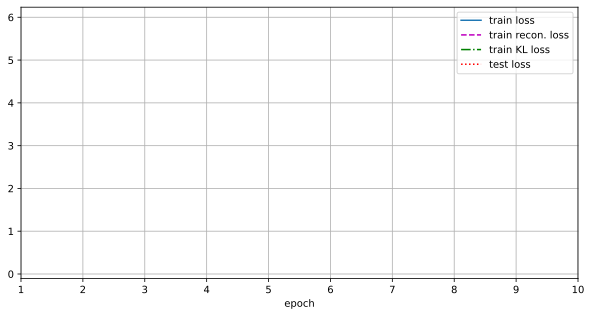

In [8]:
device = d2l.try_gpu()
model = VAE().to(device)
train(model)

**(c) If you increase the number of latent dimensions, how does that affect the reconstruction loss and the KL loss terms?<span style="float:right"> (1 point)</span>**

Losses should be reduced when the latent variable has more dimensions since it is better capable of representing each of the inputs and less information is lost for later reconstructing it. Eventually a latent variable will be fully capable of representing all the inputs and the loss will be minimized.

## 9.5 Visualizing the latent space (8 points)

We can use the function below to visualize the 2D latent space, by running the decoder on $z$ values sampled at regular intervals.

**(a) Complete the code below and run it to plot the latent space.<span style="float:right"> (1 point)</span>**

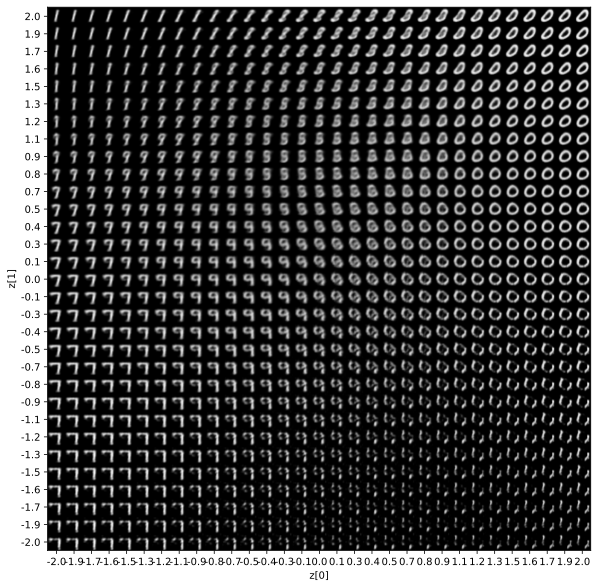

In [9]:
def plot_latent(model):
    # display a n*n 2D manifold of digits
    n = 31
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.Tensor([xi,yi]).to(device)
            x_decoded = model.decode(z)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(model)

**(b) Would it be possible to classify digits based on this latent representation? Explain your answer.<span style="float:right"> (1 point)</span>**

It would be difficult to classify all the digits based on the latent representation because as we can see in the plot it is not easy to identify and distinguish a number from a different one under this representation. This architecture has no control over which number is being generated because no labels are fed to it. We should give some label information to the system, so that we can better perform classification.

**(c) If you retrain the model, would you expect the latent space to look exactly the same. If not, what differences can you expect?<span style="float:right"> (1 point)</span>**

The one problem for generating data with VAE is we do not have any control over what kind of data it generates. So every time that we try to generate images into the decoder, it will produce different random digits.

Another way of visualizing the latent space is by making a scatter plot of the training data in the latent space.

**(d) Complete and run the code below to make a scatterplot of the training data.<span style="float:right"> (1 point)</span>**

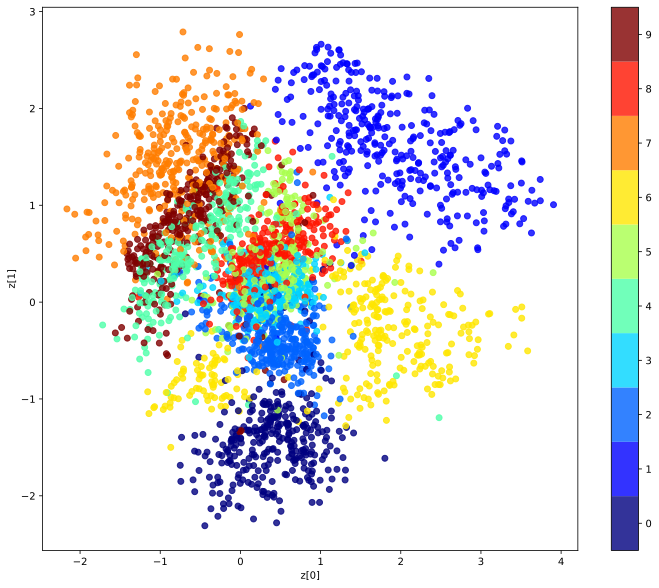

In [ ]:
def scatterplot_latent(model):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for x, y in itertools.islice(train_iter, 100):
        x = x.to(device)
        z_mean, logvar_z = model.encode(x)
        # TODO: compute mean z
        
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()
    
    cmap = plt.get_cmap('jet', 10)
    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys, cmap=cmap, alpha=0.8, vmin=-0.5, vmax=9.5)
    plt.colorbar(ticks=np.arange(0, 10))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

scatterplot_latent(model)

**(e) Compare this figure to the one from `plot_latent`. How are the plots related?<span style="float:right"> (1 point)</span>**

Note: Don't just answer "both visualize the latent space"

We ca see in the scatter_Plot how the vast majority of the clusters( one for each number) are overlapping in the middle of the plot.However, the few clusters that are far from the middle of the graph represents the numbers that we can see clearly in the plot_latent, those are number 0, number 1 and number 7

**(f) Compared to the figure from `plot_latent`, what information about the VAE is shown in this figure but not in the previous one?<span style="float:right"> (1 point)</span>**

In the scatter_plot we can see how is the distribution of the different classes and the amount of each one of this classes. Otherwise, in the plot_latent we only see the distribution of the classes. Moreover, in the scatter_plot we also see that the most of the classes are overlapping in the values between [-1,1] in both axes of the plot.

**(g) What distribution should we expect the points in the latent space to follow, based on the KL divergence term in the loss function?<span style="float:right"> (1 point)</span>**

The KL divergence tells us how well the standard normal distribution approximates an a normal distribution with given mean and log-variance. Lower the KL divergence value, the better we have matched the true distribution with our approximation

**(h) Look at the distribution of the data in the latent space. Does the plot match the answer to the previous question? If not, why?<span style="float:right"> (1 point)</span>**

The distribution appears to have multiple modes instead of a single one like a regular gaussian. This is because each number has its own gaussian mode separate from the other numbers whose geometric characteristics are more different.


## 9.6 Conditional Variational Autoencoder (10 points)

An extension of variational autoencoders uses labels to *condition* the encoder and decoder models.
In this *conditional VAE*, the decoder becomes $P(x|z,y)$ and the encoder $Q(z|x,y)$.
In practice, this means that the label $y$ is given as an extra input to the both the encoder and the decoder.

For details see the paper [Semi-Supervised Learning with Deep Generative Models; Kingma, Rezende, Mohamed, Welling; 2014](https://arxiv.org/pdf/1406.5298.pdf).

To use the labels in the decoder, we can concatenate the label with the latent vector. Or equivalently, we can use separate weights for $z$ and $y$ in the first layer, so that layer computes $W_z \cdot z + W_y \cdot y + b$.

Similarly for the encoder, except there we will still use a convolutional layer for $x$, combined with a fully connected layer for $y$.

**(a) Complete the implementation of the conditional VAE below.<span style="float:right"> (3 points)</span>**

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_size=2, num_classes=10):
        super(ConditionalVAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        # TODO: split the first layer from the previous encoder network into a separate variable,
        #       and add a layer to use with the y input


        self.encoder_part1_x =  nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2)
        )
        self.encoder_part1_y = nn.Sequential(
            nn.Linear(10, 6272)
        )

        self.encoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)

        # Components of the decoder network
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        # TODO: add layer to use with the y input
        self.decoder_part1_y = nn.Linear(10, 7*7*64)
        self.decoder_part1_yz = nn.Linear(7*7*64*2, 7*7*64)

        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: see VAE
            nn.Sigmoid() 
        )

    def encode(self, x, y):

        h = self.encoder_part1_x(x) + self.encoder_part1_y(y).reshape(-1,32,14,14)
        h = self.encoder_part2(h)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        eps = torch.randn_like(mean_z)
        std_z = torch.exp(0.5 * logvar_z)
        return eps.mul(std_z).add_(mean_z)

    def decode(self, z, y):
        # TODO: use a first layer that combines z and y
        processed_y, processed_z = self.decoder_part1_y(y), self.decoder_part1_z(z)
        h = self.decoder_part1_yz(torch.cat((processed_y, processed_z), dim=1))
        h = torch.reshape(h, (-1,64,7,7))
        return self.decoder_part2(h)

    def forward(self, x, y):
        mean_z, logvar_z = self.encode(x, y)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z, y), mean_z, logvar_z

**(b) Copy the training code from section 9.4, and modify it for a conditional VAE.<span style="float:right"> (1 point)</span>**

Hint: To train the conditional VAE we need to use one-hot encoding of the labels. You can use the following code for that:

    y = F.one_hot(y,10).float().to(device)

In [ ]:
from torch.nn.modules import loss
def train_cvae(model, num_epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], figsize=(10, 5),
                            legend=['train loss', 'train recon. loss', 'train KL loss',
                                    'test loss', 'test recon. loss', 'test KL loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for x, y in train_iter:
            x = x.to(device)
            y = F.one_hot(y,10).float().to(device)#
            optimizer.zero_grad()
            recon_x,mean_z,logvar_z = model(x,y)
            loss,loss_recon,loss_kl = loss_function(recon_x, x, mean_z, logvar_z)
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(loss_recon.detach(), loss_kl.detach(), x.shape[0])
        # Compute test loss
        test_loss, test_loss_recon, test_loss_kl = test_cvae(model)
        # Plot
        train_loss_recon = metric[0] / metric[2]
        train_loss_kl    = metric[1] / metric[2]
        train_loss = train_loss_recon + train_loss_kl
        animator.add(epoch + 1,
                     (train_loss, train_loss_recon, train_loss_kl,
                      test_loss, test_loss_recon, test_loss_kl))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_recon:.3f}, test reconstruction loss {test_loss_recon:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')


def test_cvae(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iter):
            x = x.to(device)
            y = F.one_hot(y,10).float().to(device)#
            recon_x,mean_z,logvar_z = model(x,y)
            loss,loss_recon,loss_kl = loss_function(recon_x, x, mean_z, logvar_z)
          
            metric.add(loss_recon, loss_kl, x.shape[0])
    test_loss_recon = metric[0] / metric[2]
    test_loss_kl    = metric[1] / metric[2]
    return test_loss_recon + test_loss_kl, test_loss_recon, test_loss_kl

**(c) Train a conditional VAE**

training loss 4.558, test loss 4.572
training reconstruction loss 4.478, test reconstruction loss 4.492
training KL loss 0.080, test KL loss 0.080


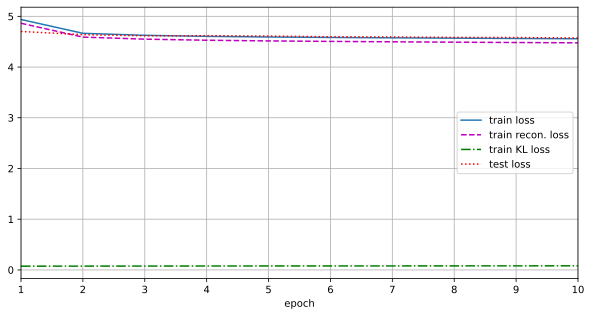

In [ ]:
device = d2l.try_gpu()
cvae_model = ConditionalVAE().to(device)
train_cvae(cvae_model)

**(d) Adapt the `plot_latent` function from section 9.5 for conditional VAEs, and use your function to visualize the latent space for the classes `4` and `8`.<span style="float:right"> (1 point)</span>**

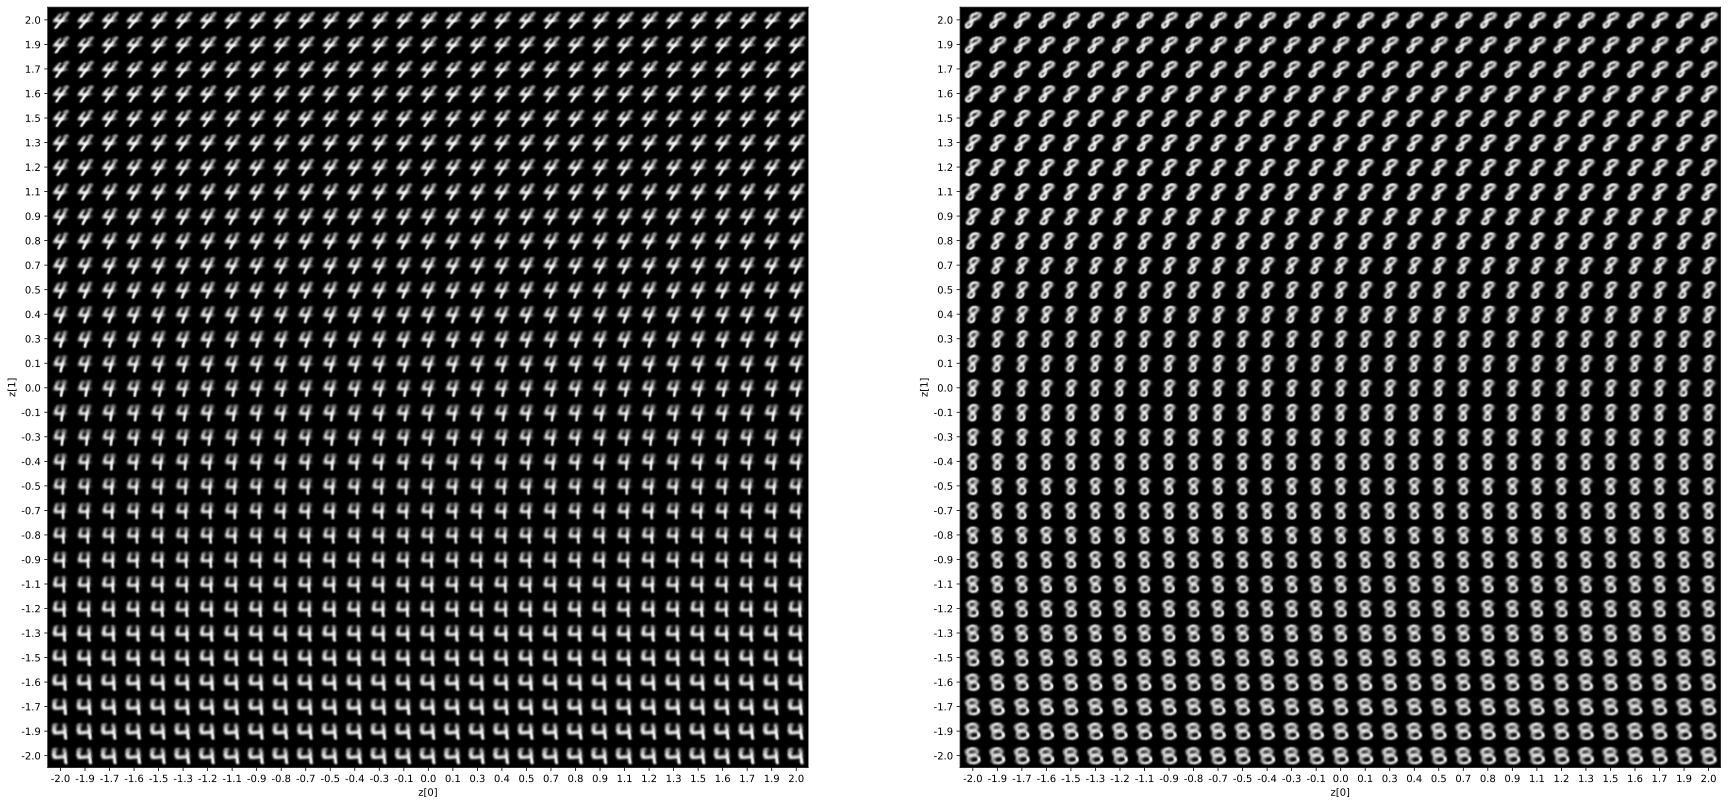

In [ ]:
def plot_latent_cvae(model):
  # display a n*n 2D manifold of digits
    n = 31
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure4 = np.zeros((digit_size * n, digit_size * n))
    figure8 = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # TODO: run the decoder on z = [xi,yi].
            z = torch.Tensor([[xi,yi] ,[xi,yi]]).to(device)
            y_index = torch.Tensor([4, 8]).to(torch.int64)
            y = F.one_hot(y_index,10).float().to(device)
            x_decoded = cvae_model.decode(z, y)
            x_4 = x_decoded[0]
            x_8 = x_decoded[1]
            figure4[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_4.detach().cpu().numpy()
            figure8[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_8.detach().cpu().numpy()

    #plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    f, ((ax1), (ax2)) = plt.subplots(1,2, figsize=(30, 30))
    ax1.imshow(figure4, cmap="Greys_r")
    ax1.xaxis.set_ticks(pixel_range)
    ax1.xaxis.set_ticklabels(sample_range_x)
    ax1.yaxis.set_ticks(pixel_range)
    ax1.yaxis.set_ticklabels(sample_range_y)
    ax1.set_xlabel("z[0]")
    ax1.set_ylabel("z[1]")
    ax2.imshow(figure8, cmap="Greys_r")
    ax2.xaxis.set_ticks(pixel_range)
    ax2.xaxis.set_ticklabels(sample_range_x)
    ax2.yaxis.set_ticks(pixel_range)
    ax2.yaxis.set_ticklabels(sample_range_y)
    ax2.set_xlabel("z[0]")
    ax2.set_ylabel("z[1]")


plot_latent_cvae(cvae_model)

**(e) What do the latent dimensions represent? Is this the same for all labels?<span style="float:right"> (1 point)</span>**

The latent dimensions are lower dimensional representations of the input of each labeled number. When decoded, it could regenerate a specific noisy version of teh encoded number. All labels could be represented and decoded with function.

**(f) Adapt `scatterplot_latent` to show the distribution in the latent space.<span style="float:right"> (1 point)</span>**

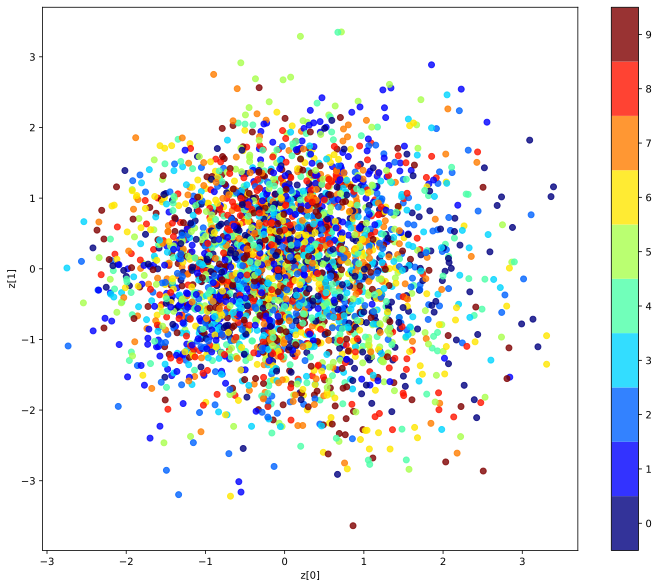

In [ ]:
def scatterplot_latent_cvae(cvae_model):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for x, y in itertools.islice(train_iter, 100):
        x = x.to(device)
        y_one_hot = F.one_hot(y,10).float().to(device)
        z_mean, logvar_z = cvae_model.encode(x, y_one_hot)
        
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()
    
    cmap = plt.get_cmap('jet', 10)
    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys, cmap=cmap, alpha=0.8, vmin=-0.5, vmax=9.5)
    plt.colorbar(ticks=np.arange(0, 10))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

scatterplot_latent_cvae(cvae_model)

**(g) How is this distribution in the latent space different from the distribution of the VAE? Compare to your answer to that for question 9.5 g and h. What is the cause of these differences?<span style="float:right"> (1 point)</span>**

This represents a conditional gaussian distribution, since it is a sub-set of a gaussian distribution variable conditioning on the rest of the variables. Since we have already verified that the variables are gaussian in 9.5.
Unlike the other distribution, does not have too many modes or clearly separable clusters since the variable result is conditioned on a set of variables of the latent space. 

**(h) Would it be possible to classify digits based on the latent representation of the conditional VAE? Explain your answer.<span style="float:right"> (1 point)</span>**

Yes, it would be perfectly possible since they are correctly associated with their respective labels, so it is easy to identify and distinguish a number from a differnet one under this representation.

**(i) Describe how you could use a conditional VAE to change the label or content of an image, while keeping the style as similar as possible.<span style="float:right"> (1 point)</span>**

I should just obtain the closest example whose label is different. This means obtaining the less noisy version of the number that is assured to get a different label by making the minimum possible changes in the latent representation variables.

## 9.7 Discussion (2 points)

**(a) Is the conditional VAE a strict improvement over the normal VAE in all cases?<span style="float:right"> (1 point)</span>**

Conditional VAE allows us to actually control which data will be generated from the latent space. This could be deemed neccesary when dealing with the generation of elements from a multiclass dataset like our numbers in this case. However, if we just want to generate random elements with no control over what is being geenrated, VAE alone could be an easier an non biased solution we could use to get better results.

**(b) Compare the latent representation vector $z$ in the VAE with the input for the generator in a GAN. They are both small vectors, and they are both often called $z$. In what way are they the same, and in what way are the different?<span class="float:right"> (1 point)</span>**

They are similar in the way that they are variables that are used to produce a representation of an original input (either a noisy or a lower dimensional version of it). The main difference is that the GAN input is intended to generate a fake input aiming to get classified as valid, while the autoencoder aims to generate a smaller representation of an input, which must be possible to be fully regenerated from it.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 28 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 3057449 / 2022-11-15</span>